STEP 0: Prepare
Import all necessary libraries
Obtain raw data and ferment it into a processable dataset

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

Dataset description
A total of 20000+ different Audio files(.WAV) used, with the following categories of words available in them:

'bed'
 'bird'
 'cat'
 'dog'
 'down'
 'eight'
 'five'
 'four'
 'go'
 'happy'
 'house'
 'left'
 'marvin'
 'nine'
 'no'
 'off'
 'on'
 'one'
 'right'
 'seven'
 'sheila'
 'six'
 'stop'
 'three'
 'tree'
 'two'
 'up'
 'wow'
 'yes'
 'zero'
 '_background_noise_'

In [52]:
os.listdir(r"D:\speech recog\train\audio")

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero',
 '_background_noise_']

Data Exploration and Visualization

helps us to understand the data as well as pre-processing steps in a better way. 
Visualization of Audio signal in time series domain

Now, we’ll visualize the audio signal in the time series domain:

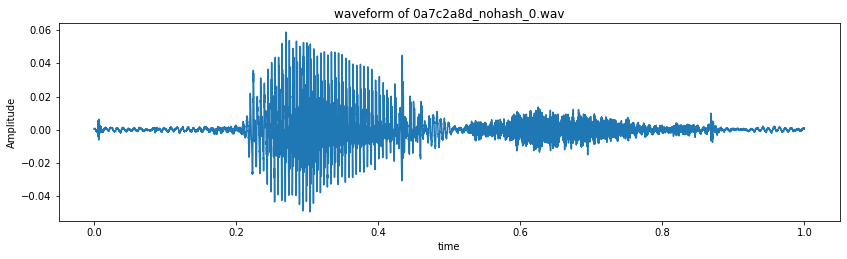

In [3]:
train_audio_path = 'D:/speech recog/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/00f0204f_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('waveform of ' + "0a7c2a8d_nohash_0.wav")
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [4]:
ipd.Audio(samples, rate=sample_rate)

In [5]:
print(sample_rate)

16000


**Resampling**

From the above, we can understand that the sampling rate of the signal is 16000 hz. Let us resample it to 8000 hz since most of the speech related frequencies are present in 8000z 

In [6]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

Now, let’s understand the number of recordings for each voice command:

In [7]:
labels=os.listdir(train_audio_path)

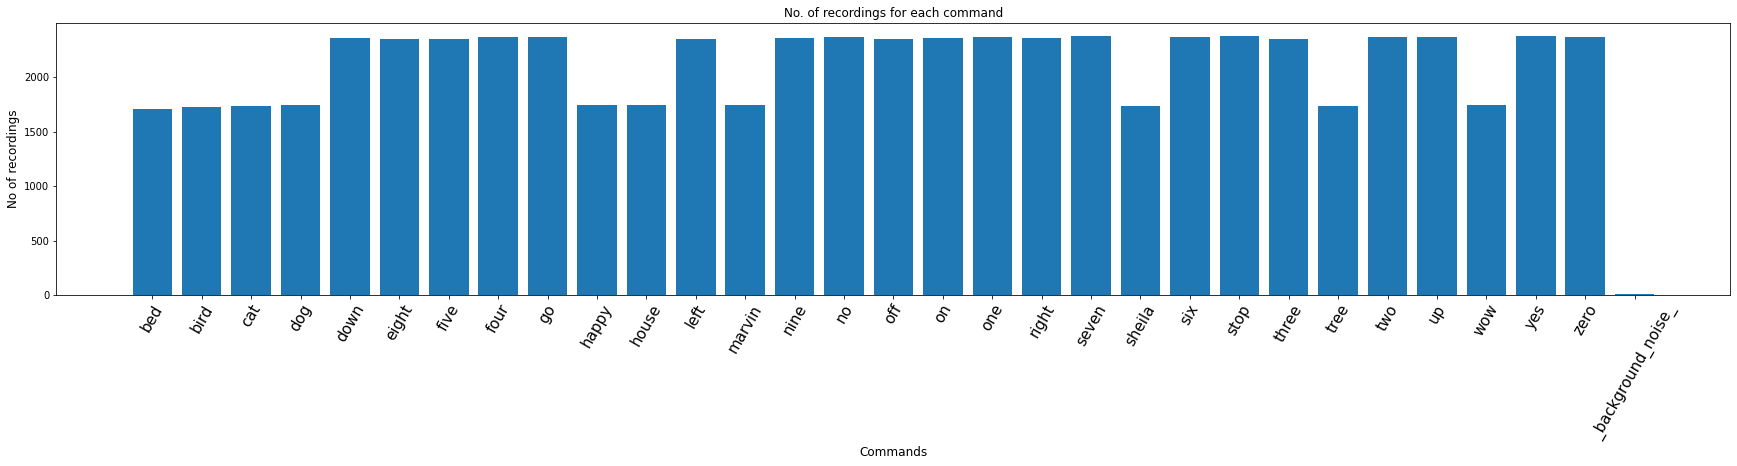

In [8]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [9]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

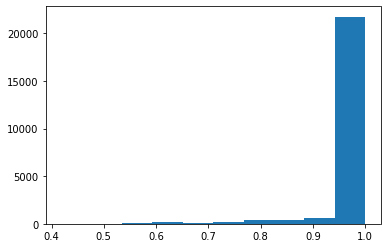

In [10]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

Preprocessing the audio waves

In the data exploration part earlier, we have seen that the duration of a few recordings is less than 1 second and the sampling rate is too high. So, let us read the audio waves and use the below-preprocessing steps to deal with this.

Here are the two steps we’ll follow:


Resampling

Removing shorter commands of less than 1 second

Let us define these preprocessing steps in the below code snippet:

In [11]:


all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


Convert the output labels to integer encoded:

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [13]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [14]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

**Split into train and validation set**

Next, we will train the model on 80% of the data and validate on 10% and the remaining 10% for testing:


In [27]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.1,random_state=777,shuffle=True)

**Model Architecture for this problem**

We will build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension. 

Here is the model architecture:
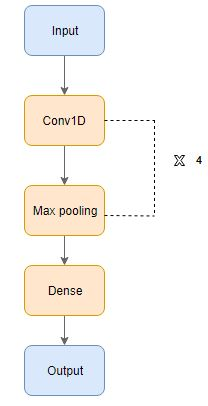

**Model building**

Let us implement the model using Keras functional API.

In [28]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

def build_model():

    inputs = Input(shape=(8000,1))

    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)
    
    #Flatten layer
    conv = Flatten()(conv)

    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    outputs = Dense(len(labels), activation='softmax')(conv)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
model=build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

STEP 5: Training with Cross Validation

Agenda:

use k=10 folds

use x_train and y_train for splitting into separate k fold validation sets

store training results of each fold

plot graphs for all k-fold validation sessions

In [29]:
#parameter 1:
num_val_samples = int(len(x_tr)/10)
history=[]
all_acc=[]
all_models=[]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
for i in range(10):
    print('\nprocessing fold #', i+1)
    val_data = x_tr[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_tr[i * num_val_samples: (i + 1) * num_val_samples]
    partial_x_train = np.concatenate([x_tr[:i * num_val_samples],x_tr[(i + 1) * num_val_samples:]],axis=0)
    partial_y_train = np.concatenate([y_tr[:i * num_val_samples],y_tr[(i + 1) * num_val_samples:]],axis=0)
    print(partial_x_train.shape)
#    partial_x_train, val_data, partial_y_train, val_targets = train_test_split(x_tr,y_tr,stratify=y,test_size = 0.1,random_state=777,shuffle=True)
    model=build_model()
    #mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    current_history=model.fit(partial_x_train, partial_y_train ,epochs=50, callbacks=[es], batch_size=32, validation_data=(val_data,val_targets))
    all_models.append(model)
    history.append(current_history)
    print('='*100)


processing fold # 1
(17262, 8000, 1)
Train on 17262 samples, validate on 1918 samples
Epoch 1/50
17262/17262 [==============================] - 116s 7ms/step - loss: 2.0661 - accuracy: 0.2139 - val_loss: 1.6950 - val_accuracy: 0.3691
Epoch 2/50
17262/17262 [==============================] - 115s 7ms/step - loss: 1.5204 - accuracy: 0.4317 - val_loss: 1.2514 - val_accuracy: 0.5516
Epoch 3/50
17262/17262 [==============================] - 114s 7ms/step - loss: 1.2690 - accuracy: 0.5372 - val_loss: 1.0800 - val_accuracy: 0.6251
Epoch 4/50
17262/17262 [==============================] - 114s 7ms/step - loss: 1.1057 - accuracy: 0.6062 - val_loss: 0.9975 - val_accuracy: 0.6340
Epoch 5/50
17262/17262 [==============================] - 115s 7ms/step - loss: 0.9782 - accuracy: 0.6613 - val_loss: 0.8383 - val_accuracy: 0.7200
Epoch 6/50
17262/17262 [==============================] - 115s 7ms/step - loss: 0.8866 - accuracy: 0.6932 - val_loss: 0.7364 - val_accuracy: 0.7560
Epoch 7/50
17262/17262 [=

17262/17262 [==============================] - 117s 7ms/step - loss: 0.4202 - accuracy: 0.8548 - val_loss: 0.4919 - val_accuracy: 0.8379
Epoch 20/50
17262/17262 [==============================] - 117s 7ms/step - loss: 0.4130 - accuracy: 0.8593 - val_loss: 0.5144 - val_accuracy: 0.8269
Epoch 21/50
17262/17262 [==============================] - 117s 7ms/step - loss: 0.3882 - accuracy: 0.8676 - val_loss: 0.4952 - val_accuracy: 0.8399
Epoch 22/50
17262/17262 [==============================] - 116s 7ms/step - loss: 0.3896 - accuracy: 0.8665 - val_loss: 0.4781 - val_accuracy: 0.8436
Epoch 23/50
17262/17262 [==============================] - 118s 7ms/step - loss: 0.3941 - accuracy: 0.8632 - val_loss: 0.4758 - val_accuracy: 0.8389
Epoch 24/50
17262/17262 [==============================] - 117s 7ms/step - loss: 0.3666 - accuracy: 0.8721 - val_loss: 0.4822 - val_accuracy: 0.8321
Epoch 25/50
17262/17262 [==============================] - 117s 7ms/step - loss: 0.3684 - accuracy: 0.8719 - val_loss:

Epoch 29/50
17262/17262 [==============================] - 80s 5ms/step - loss: 0.3286 - accuracy: 0.8880 - val_loss: 0.4650 - val_accuracy: 0.8551
Epoch 30/50
17262/17262 [==============================] - 80s 5ms/step - loss: 0.3141 - accuracy: 0.8920 - val_loss: 0.4916 - val_accuracy: 0.8446
Epoch 31/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.3162 - accuracy: 0.8924 - val_loss: 0.4982 - val_accuracy: 0.8467
Epoch 32/50
17262/17262 [==============================] - 80s 5ms/step - loss: 0.3047 - accuracy: 0.8949 - val_loss: 0.4457 - val_accuracy: 0.8670
Epoch 33/50
17262/17262 [==============================] - 80s 5ms/step - loss: 0.2971 - accuracy: 0.8993 - val_loss: 0.4301 - val_accuracy: 0.8608
Epoch 34/50
17262/17262 [==============================] - 80s 5ms/step - loss: 0.3004 - accuracy: 0.8975 - val_loss: 0.5095 - val_accuracy: 0.8420
Epoch 00034: early stopping

processing fold # 4
(17262, 8000, 1)
Train on 17262 samples, validate on 1918 sampl

17262/17262 [==============================] - 81s 5ms/step - loss: 1.9939 - accuracy: 0.2425 - val_loss: 1.6319 - val_accuracy: 0.4072
Epoch 2/50
17262/17262 [==============================] - 81s 5ms/step - loss: 1.4636 - accuracy: 0.4541 - val_loss: 1.2007 - val_accuracy: 0.5719
Epoch 3/50
17262/17262 [==============================] - 81s 5ms/step - loss: 1.2290 - accuracy: 0.5555 - val_loss: 1.0490 - val_accuracy: 0.6606
Epoch 4/50
17262/17262 [==============================] - 81s 5ms/step - loss: 1.0707 - accuracy: 0.6210 - val_loss: 0.9304 - val_accuracy: 0.6778
Epoch 5/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.9915 - accuracy: 0.6513 - val_loss: 0.8234 - val_accuracy: 0.7289
Epoch 6/50
17262/17262 [==============================] - 83s 5ms/step - loss: 0.8899 - accuracy: 0.6861 - val_loss: 0.7907 - val_accuracy: 0.7461
Epoch 7/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.8195 - accuracy: 0.7192 - val_loss: 0.7339 - val

17262/17262 [==============================] - 82s 5ms/step - loss: 0.4819 - accuracy: 0.8311 - val_loss: 0.5603 - val_accuracy: 0.8160
Epoch 18/50
17262/17262 [==============================] - 80s 5ms/step - loss: 0.4723 - accuracy: 0.8412 - val_loss: 0.5786 - val_accuracy: 0.8285
Epoch 19/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.4546 - accuracy: 0.8420 - val_loss: 0.5393 - val_accuracy: 0.8311
Epoch 20/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.4485 - accuracy: 0.8449 - val_loss: 0.6210 - val_accuracy: 0.7961
Epoch 21/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.4337 - accuracy: 0.8500 - val_loss: 0.4955 - val_accuracy: 0.8509
Epoch 22/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.4199 - accuracy: 0.8544 - val_loss: 0.5377 - val_accuracy: 0.8306
Epoch 23/50
17262/17262 [==============================] - 82s 5ms/step - loss: 0.4033 - accuracy: 0.8586 - val_loss: 0.5031

17262/17262 [==============================] - 74s 4ms/step - loss: 0.3411 - accuracy: 0.8849 - val_loss: 0.4353 - val_accuracy: 0.8509
Epoch 31/50
17262/17262 [==============================] - 75s 4ms/step - loss: 0.3218 - accuracy: 0.8911 - val_loss: 0.4440 - val_accuracy: 0.8545
Epoch 32/50
17262/17262 [==============================] - 78s 5ms/step - loss: 0.3321 - accuracy: 0.8894 - val_loss: 0.4673 - val_accuracy: 0.8425
Epoch 33/50
17262/17262 [==============================] - 73s 4ms/step - loss: 0.3182 - accuracy: 0.8913 - val_loss: 0.4522 - val_accuracy: 0.8441
Epoch 34/50
17262/17262 [==============================] - 76s 4ms/step - loss: 0.3032 - accuracy: 0.8953 - val_loss: 0.4654 - val_accuracy: 0.8457
Epoch 35/50
17262/17262 [==============================] - 74s 4ms/step - loss: 0.3057 - accuracy: 0.8981 - val_loss: 0.4399 - val_accuracy: 0.8472
Epoch 36/50
17262/17262 [==============================] - 75s 4ms/step - loss: 0.2972 - accuracy: 0.8970 - val_loss: 0.4569

Epoch 37/50
17262/17262 [==============================] - 77s 4ms/step - loss: 0.2932 - accuracy: 0.9010 - val_loss: 0.5636 - val_accuracy: 0.8295
Epoch 38/50
17262/17262 [==============================] - 74s 4ms/step - loss: 0.2890 - accuracy: 0.9029 - val_loss: 0.6137 - val_accuracy: 0.8144
Epoch 39/50
17262/17262 [==============================] - 75s 4ms/step - loss: 0.2870 - accuracy: 0.9005 - val_loss: 0.6003 - val_accuracy: 0.8264
Epoch 40/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.2749 - accuracy: 0.9068 - val_loss: 0.5836 - val_accuracy: 0.8368
Epoch 41/50
17262/17262 [==============================] - 78s 5ms/step - loss: 0.2681 - accuracy: 0.9086 - val_loss: 0.5559 - val_accuracy: 0.8352
Epoch 42/50
17262/17262 [==============================] - 78s 5ms/step - loss: 0.2768 - accuracy: 0.9084 - val_loss: 0.5677 - val_accuracy: 0.8290
Epoch 43/50
17262/17262 [==============================] - 75s 4ms/step - loss: 0.2681 - accuracy: 0.9090 - val_

17262/17262 [==============================] - 81s 5ms/step - loss: 0.2822 - accuracy: 0.9057 - val_loss: 0.5001 - val_accuracy: 0.8519
Epoch 42/50
17262/17262 [==============================] - 81s 5ms/step - loss: 0.2773 - accuracy: 0.9043 - val_loss: 0.4984 - val_accuracy: 0.8509
Epoch 00042: early stopping

processing fold # 10
(17262, 8000, 1)
Train on 17262 samples, validate on 1918 samples
Epoch 1/50
17262/17262 [==============================] - 81s 5ms/step - loss: 2.0468 - accuracy: 0.2302 - val_loss: 1.7074 - val_accuracy: 0.3733
Epoch 2/50
17262/17262 [==============================] - 80s 5ms/step - loss: 1.5109 - accuracy: 0.4337 - val_loss: 1.2838 - val_accuracy: 0.5433
Epoch 3/50
17262/17262 [==============================] - 81s 5ms/step - loss: 1.2533 - accuracy: 0.5451 - val_loss: 1.0973 - val_accuracy: 0.6225
Epoch 4/50
17262/17262 [==============================] - 81s 5ms/step - loss: 1.1082 - accuracy: 0.6021 - val_loss: 0.9868 - val_accuracy: 0.6554
Epoch 5/50
1

In [30]:
model.save('model_110723.hdf5')

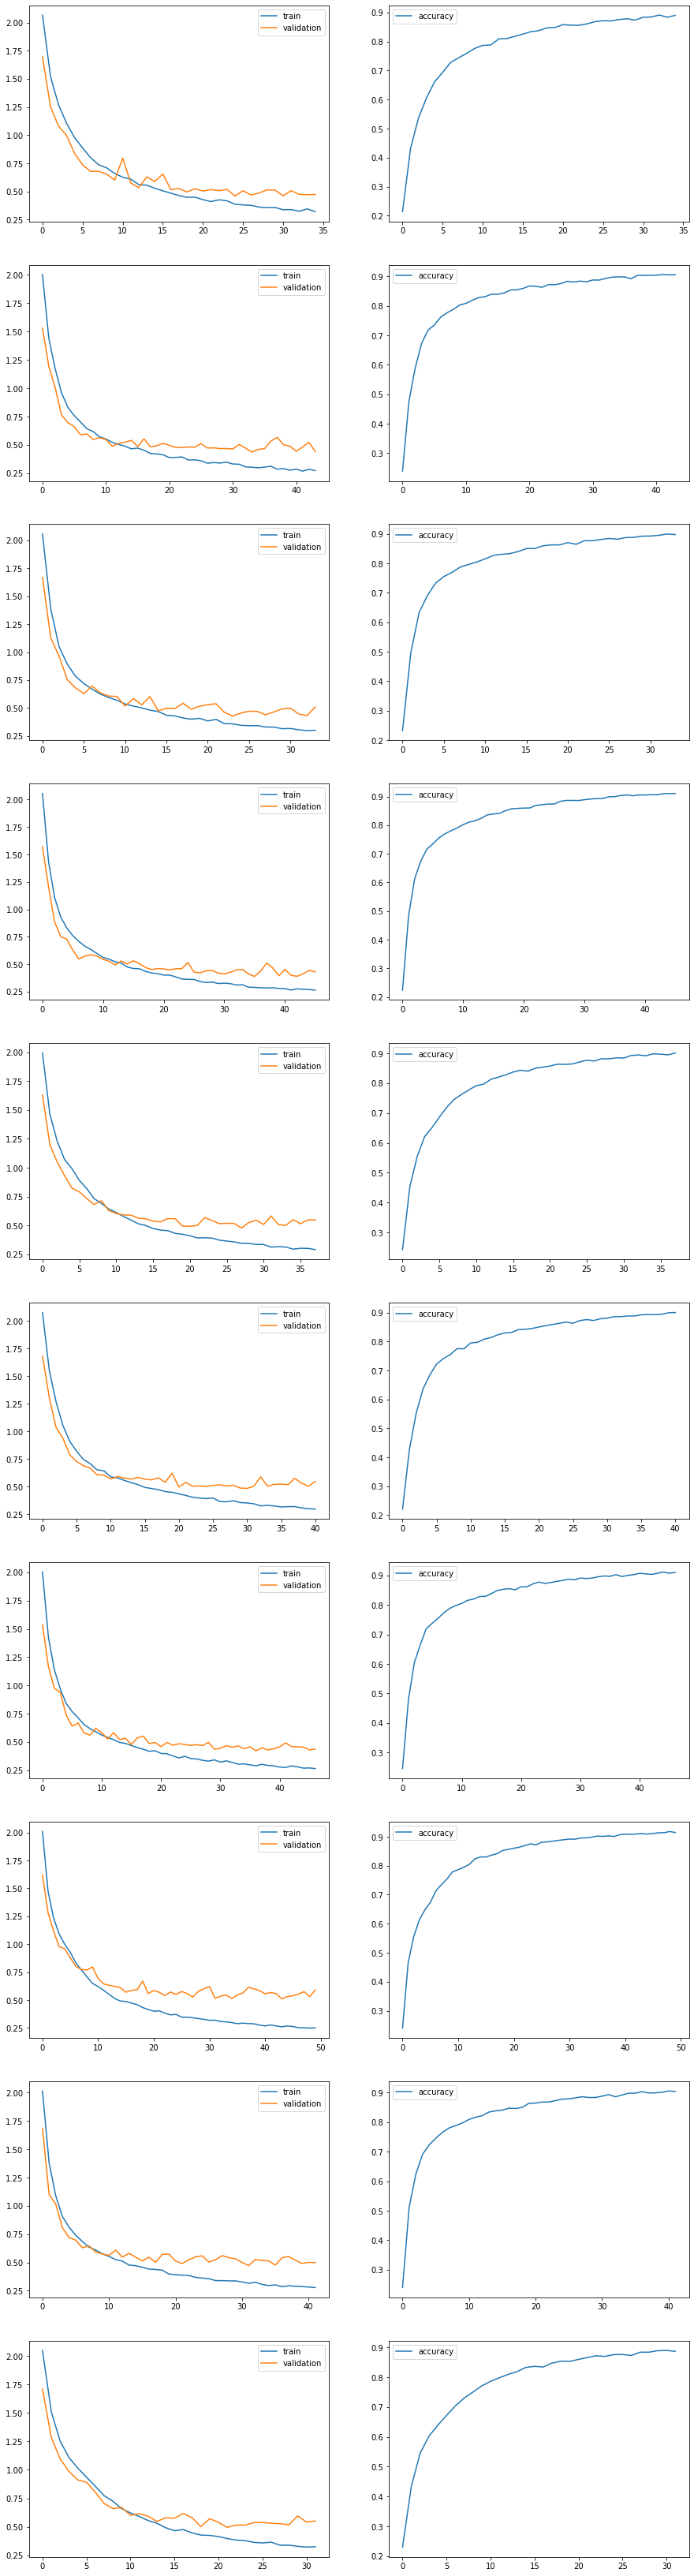

In [32]:
from matplotlib import pyplot
fig=pyplot.figure(figsize=(15,120))
for i in range(10):
    ax=fig.add_subplot(20,2,2*i+1)
    ax.plot(history[i].history['loss'], label='train')
    ax.plot(history[i].history['val_loss'], label='validation')
    ax.legend()

    
    ax2=fig.add_subplot(20,2,2*i+2)
    ax2.plot(history[i].history['accuracy'], label='accuracy')
    ax2.legend()

**Loading the best model**

In [33]:
from keras.models import load_model
model=load_model('model_110723.hdf5')

Define the function that predicts text for the given audio:

In [34]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

 Make predictions on the validation data:

In [35]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: right


In [36]:
print("Text:",predict(samples))

Text: right


STEP 5: Testing and scoring using different performance matrix and WER%

In [37]:
model1=all_models[3]
y_pred=model1.predict(x_val)
for i in range(0,len(y_pred)):
    mval=max(y_pred[i]);
    for j in range(0,len(y_pred[i])):
        if(y_pred[i][j]==mval):
           y_pred[i][j]=1
        else:
            y_pred[i][j]=0
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [38]:
y_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
ytest=np.zeros(len(y_val),dtype=int)
ypred=np.zeros(len(y_pred),dtype=int)
for i in range(0,len(y_val)):
    for j in range(0,10):
        if(y_val[i][j]==1):
           ytest[i]=j+1
           break
for i in range(0,len(y_pred)):
    for j in range(0,10):
        if(y_pred[i][j]==1):
           ypred[i]=j+1
           break
ypred

array([6, 5, 1, ..., 3, 7, 2])

In [40]:
ytest

array([6, 5, 1, ..., 3, 7, 2])

In [41]:
from sklearn.metrics import confusion_matrix
cf=[]
cf=confusion_matrix(ytest,ypred)
cf

array([[181,   5,   2,  10,   2,   3,   0,   7,   3,   2],
       [ 11, 152,   4,  18,   3,   1,   1,  10,   3,   7],
       [  0,   0, 173,   2,   5,   1,   6,   3,   4,  23],
       [  1,   9,   5, 182,   3,   1,   0,   1,   1,   7],
       [  1,   0,   0,   3, 187,   6,   0,   2,  14,   1],
       [  2,   1,   0,   1,  16, 182,   3,   0,   6,   0],
       [  0,   1,  11,   0,   2,   0, 196,   1,   4,   1],
       [  3,   3,   1,   2,  10,   0,   0, 187,   8,   3],
       [  1,   1,   2,   0,  16,   2,   1,   9, 173,   1],
       [  1,   0,   8,   1,   2,   0,   2,   0,   2, 200]], dtype=int64)

In [42]:
correct=[]
wrong=[]
for i in range(len(cf)):
    sum=0
    temp=cf[i][i]
    for j in range(len(cf[i])):
        sum=sum+cf[i][j]
    wrong.append(sum-temp)
    correct.append(temp)
correct


[181, 152, 173, 182, 187, 182, 196, 187, 173, 200]

In [43]:
wrong

[34, 58, 44, 28, 27, 29, 20, 30, 33, 16]

In [44]:
from sklearn.metrics import f1_score
f1_score(ytest,ypred,average='weighted')

0.8504025484626657

In [45]:
from sklearn.metrics import precision_score,recall_score,confusion_matrix,classification_report,accuracy_score,f1_score
precision_score(ytest,ypred,average='weighted')

0.8543003418650301

In [46]:
accuracy=accuracy_score(ytest,ypred)
accuracy

0.850375234521576

In [47]:
recall_score(ytest,ypred,average='weighted')

0.850375234521576

In [48]:
classification_report(ytest,ypred)

'              precision    recall  f1-score   support\n\n           1       0.90      0.84      0.87       215\n           2       0.88      0.72      0.80       210\n           3       0.84      0.80      0.82       217\n           4       0.83      0.87      0.85       210\n           5       0.76      0.87      0.81       214\n           6       0.93      0.86      0.89       211\n           7       0.94      0.91      0.92       216\n           8       0.85      0.86      0.86       217\n           9       0.79      0.84      0.82       206\n          10       0.82      0.93      0.87       216\n\n    accuracy                           0.85      2132\n   macro avg       0.85      0.85      0.85      2132\nweighted avg       0.85      0.85      0.85      2132\n'

Creating a plot between correctly predicted outputs and wrong outputs

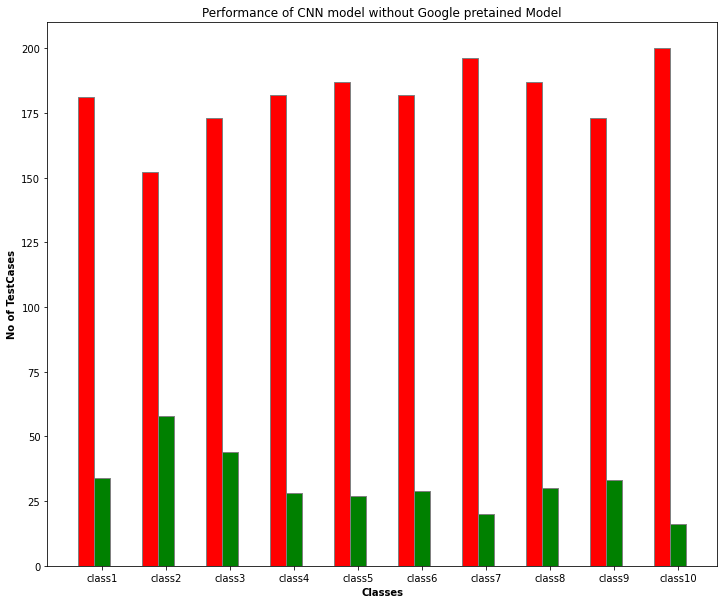

In [49]:
import matplotlib.pyplot as plt 
   
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(12, 10)) 
   
# set height of bar 


   
# Set position of bar on X axis 
br1 = np.arange(10) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
   
# Make the plot 
plt.title('Performance of CNN model without Google pretained Model') 
plt.bar(br1, correct, color ='r', width = barWidth, edgecolor ='grey', label ='Correctly predicted') 
plt.bar(br2, wrong, color ='g', width = barWidth,  edgecolor ='grey', label ='wrongly predicted') 
 
   
# Adding Xticks  
plt.xlabel('Classes', fontweight ='bold') 
plt.ylabel('No of TestCases', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(correct))], 
           ['class1', 'class2', 'class3', 'class4', 'class5', 'class6','class7','class8','class9', 'class10']) 
   
plt.show()

In [50]:
wer=1-accuracy
print(wer)

0.14962476547842396
